# Breast Cancer Campaign
Predict if a breast cancer diagnosis is Malign or Benign based on the measurements from the breast exam

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
import time
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

shap.initjs()

%matplotlib inline

In [2]:
df = pd.read_csv('breast_cancer_data.csv')
# Drop the last column because it only has missing values
df.drop(columns=['Unnamed: 32'], inplace=True)

# Create a DataFrame containig the target
target_df = df[['diagnosis']].copy()
# Create a dataframe with only the feature values
features_df = df.iloc[:,2:].copy()

# Scale features and target
X = StandardScaler().fit_transform(features_df.values)
y = LabelEncoder().fit_transform(target_df.values.ravel())

# Split data into training, validation and test sets
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.3, random_state=0)

# Train the model on the training set and adjust hyperparameters on the validation set

In [3]:
optuna.logging.set_verbosity(optuna.logging.INFO)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_xgb(trial, X_train, X_valid, y_train, y_valid):
    
    params = {
    "objective":"binary:logistic",
    "max_depth": trial.suggest_int("max_depth", 1, 10, step=1),
    "n_estimators": trial.suggest_int("n_estimators", 50, 1000, step=25),
    "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1, log=False),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }
    
    model = XGBClassifier(**params,random_state=42).fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    
    #(tn, fp, fn, tp) = confusion_matrix(y_valid, y_predicted).ravel()
    #accuracy = float(tp+tn)/float(tn+fp+fn+tp)
    score = f1_score(y_valid, y_predicted)
                             
    return score

# XGBoost training and hyperparameter tuning
study_xgb = optuna.create_study(direction = "maximize")
func = lambda trial: objective_xgb(trial, X_train, X_valid, y_train, y_valid)
study_xgb.optimize(func, n_trials = 100, timeout=600)

# Train with best trial and train and validation data
model_xgb = XGBClassifier(**study_xgb.best_trial.params).fit(X_train_valid, y_train_valid)

In [4]:
# Predict the test set
y_predicted_xgb = model_xgb.predict(X_test)
(tn, fp, fn, tp) = confusion_matrix(y_test, y_predicted_xgb).ravel()
f1_val = (2*tp)/(2*tp+fp+fn)
print("Test set f1_val =", f1_val)

Test set f1_val = 0.9647058823529412


# Explain all the predictions in the test set

In [5]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(model_xgb.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/114 [00:00<?, ?it/s]

# Show summary of all feature effects

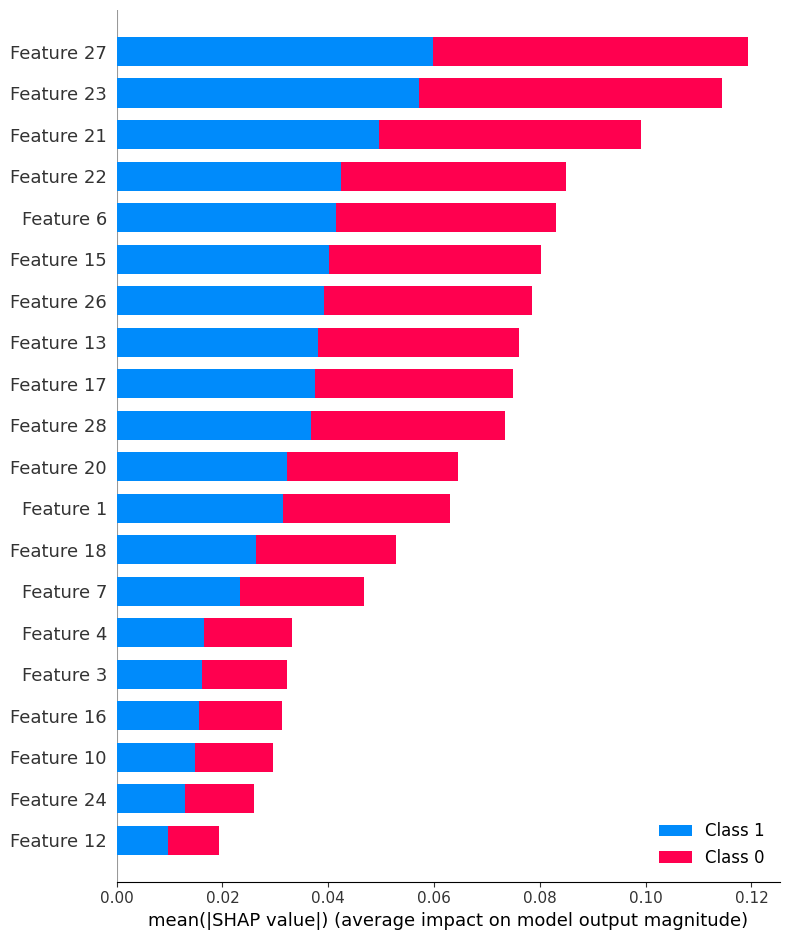

In [6]:
shap.summary_plot(shap_values, X_test,plot_type='bar') # 'dot', 'bar', 'violin', 'compact_dot'

# Use tree explainer to explain the XGBoost model

[20:46:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


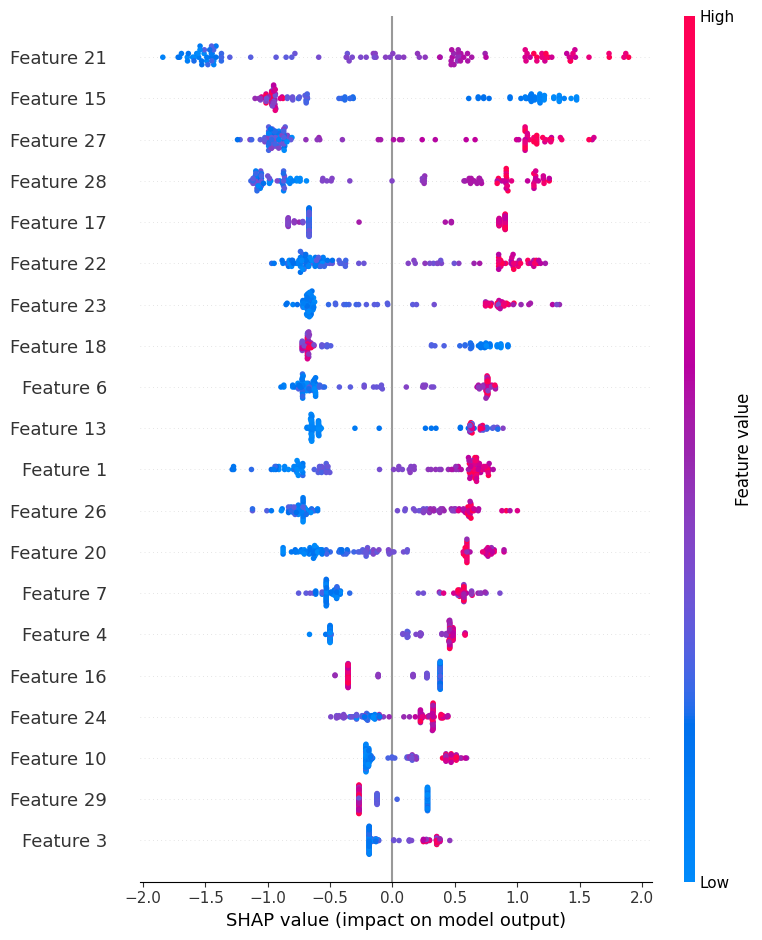

In [7]:
# Use tree explainer to explain our XGBoost model
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)